# Parametric Poisson equation 

This notebook implements Poisson equation where diffusivity is uncertain and sampled from log-normal like distribution. Dependencies are mentioned in the `neuralop.yml` file in the root directory of this repository. 

## Problem description
Consider a two dimensional domain $\Omega = (0, 1) \times (0, 1) \subset \mathbb{R}^2$ and suppose $u: \Omega \to \mathbf{R}$ denotes the temperature field. The balance of energy governs it via the differential equation:
\begin{equation}\tag{1}
    \begin{aligned}
        -\nabla \cdot \left( m(x) \nabla u(x) \right) &= f(x)\,, \qquad &\forall x \in \Omega\,, \\
        u(x) &= 0\,, \qquad &\forall x \in \Gamma_u\,, \\
        m(x) \nabla u(x)\cdot n(x) &= q(x)\,, \qquad & \forall x \in \Gamma_q\,,
    \end{aligned}
\end{equation}
where $\Gamma_u:= \left\{ x \in \partial \Omega: x_1 < 1 \right\}$ (i.e., all sides except the right side of the rectangular domain) and $\Gamma_q:= \partial \Omega - \Gamma_u$. We let
\begin{equation}\tag{2}
    f(x) = 1000 (1-x_2)x_2(1 - x_1)(1 - x_1) \qquad \text{and} \qquad q(x) = 50\sin(5\pi x_2)\,.
\end{equation}

The probability distribution for $m$ is given by
\begin{equation}\tag{3}
    m = \alpha_m * \log(w) + \mu_m, \qquad \text{where} \quad w \sim N(0, C)\,,
\end{equation}
where $N(0, C)$ denotes the Gaussian normal distribution with the mean function being zero in $L^2(\Omega, \mathbb{R})$ and $C: L^2(\Omega; \mathbb{R}) \times L^2(\Omega; \mathbb{R})\to \mathbb{R}$ a covariance operator taking the form:
\begin{equation}
    C = \begin{cases}\tag{3}
        (-\gamma_C \nabla \cdot \nabla + \delta_C)^{-d_C}\,, \qquad & \text{in } \Omega\,,\\
        \gamma_C n \cdot \nabla + \eta_C\,, \qquad & \text{on }\partial \Omega\,,
    \end{cases}
\end{equation}
with $\gamma_C, \delta_C, \eta_C, d_C$ being the parameters of a covariance operator and $n$ unit outward normal. We fix the following values of distribution parameters
\begin{equation}\tag{4}
\gamma_C = 0.8\,, \quad \delta_C = 0.2\,,\quad \eta_C = 1\,,\quad  d_C = 2\,, \quad \alpha_m = 1\,, \quad \beta_m = 1\,.
\end{equation}

Given $m\in M$, we let $F(m) = u\in U$ be the solution of boundary value problem (BVP) Eq (1), i.e., $F: M \to U$ is the solution/forward operator. 

## Random samples of m and corresponding solution u(m)

<p align="center"> <img src="./data/Poisson_sample_plots.png" width="400"> </p>

In [17]:
import sys
import os
import time
import numpy as np
import dolfin as dl
import hippylib as hp

from scipy.interpolate import griddata

util_path = "../../utilities/"
sys.path.append(util_path)
from plotUtilities import field_plot_fenics

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set seed
seed = 0
np.random.seed(seed)

In [7]:
data_folder = 'data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/' + data_folder
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Main model class
This will be ultimately moved to a python script but for now we will keep it here for testing purposes. The class has two component: (1) class to sample diffusivity field using log-normal distribution in infinite dimension and (2) class that implements the variational form and solves it. 

In [9]:
class PriorSampler:

    def __init__(self, Vm, correlation_length, seed = 0, logn_scale = 1., logn_translate = 1.):
        self.correlation_length = correlation_length
        var = self.correlation_length / 0.16
        # Delta and gamma
        self.delta = (var * self.correlation_length) ** (-0.5)
        self.gamma = self.delta * self.correlation_length ** 2

        self.seed = seed
        self.Vm = Vm

        self.prior = hp.BiLaplacianPrior(self.Vm, self.gamma, self.delta, robin_bc=True)
        self.translate = dl.Constant(logn_translate)
        self.scale = dl.Constant(logn_scale)
        
        self.parRandom = hp.Random(seed = seed)

        # initialize noise vector
        self.noise = dl.Vector()
        self.prior.init_vector(self.noise, "noise")
        self.parRandom.normal(1.,self.noise)
        
        # initialize sample
        self.sample = dl.Vector()
        self.prior.init_vector(self.sample, 0)

        # draw a sample
        self.parRandom.normal(1.,self.noise)
        self.prior.sample(self.noise, self.sample)

        self.m_local = None
        self.m_fn = dl.Function(self.Vm)
        self.m_transform_fn = dl.Function(self.Vm)

        # set mean
        self.mean = self.prior.mean.copy()
        self.transform(self.mean)

    def transform(self, m):
        self.m_fn.vector().zero()
        self.m_fn.vector().axpy(1., m)
        self.m_transform_fn = self.scale * dl.exp(self.m_fn) + self.translate
        
        self.m_local = dl.project(self.m_transform_fn, self.Vm).vector().get_local()
        m.set_local(self.m_local)


    def transform_pointwise(self, m):
        self.m_local = self.scale.values()[0]*np.exp(m.get_local()) + self.translate.values()[0]
        m.set_local(self.m_local)

    def get(self):
        self.sample.zero()
        self.parRandom.normal(1.,self.noise)
        self.prior.sample(self.noise, self.sample)

        self.transform_pointwise(self.sample)
        return self.sample
    
class PoissonModel:
    
    def __init__(self, correlation_length, seed = 0):
        
        # FE setup
        self.fe_order = 1
        self.nx = 50
        self.ny = 50
        self.mesh = dl.RectangleMesh(dl.Point(0, 0), dl.Point(1,1), self.nx, self.ny)
        self.Vu = dl.FunctionSpace(self.mesh, "Lagrange", self.fe_order)
        self.Vm = self.Vu
        self.Vh = [self.Vu, self.Vm, self.Vu] # state, parameter, adjoint

        # Boundary conditions
        self.f = dl.Expression("1000*(1-x[1])*x[1]*(1-x[0])*(1-x[0])", degree=2)
        self.q = dl.Expression("50*sin(5*pi*x[1])", degree=2)

        # variational form
        self.m_fn = dl.Function(self.Vm)
        self.u_fn = dl.Function(self.Vu)
        
        self.u_trial = dl.TrialFunction(self.Vu)
        self.u_test = dl.TestFunction(self.Vu)
        self.a = self.m_fn*dl.inner(dl.nabla_grad(self.u_trial), dl.nabla_grad(self.u_test))*dl.dx 
        self.L = self.f*self.u_test*dl.dx \
                 + self.q*self.u_test*dl.ds # boundary term
        self.varf = self.a - self.L
        
        self.bc = [dl.DirichletBC(self.Vu, dl.Constant(0), self.boundaryU)]

        # setup prior for parameter field m
        self.prior_sampler = PriorSampler(self.Vm, correlation_length, seed)
        
    @staticmethod
    def boundaryU(x, on_boundary):
        return on_boundary and x[0] < 1. - dl.DOLFIN_EPS

    def solveFwd(self, m = None, m_is_fn = True):
        if m is not None:
            self.m_fn.vector().zero()
            if m_is_fn:
                self.m_fn.vector().axpy(1., m.vector())
            else:
                self.m_fn.vector()[:] = m


        self.A = dl.assemble(self.a)
        self.b = dl.assemble(self.L)
        for bc in self.bc:
            bc.apply(self.A, self.b)
        
        dl.solve(self.A, self.u_fn.vector(), self.b)

    def samplePrior(self):
        self.m_fn.vector().zero()
        self.m_fn.vector().axpy(1., self.prior_sampler.get())

# Test Poisson model

In [10]:
correlation_length = 2
model = PoissonModel(correlation_length)
print(model.prior_sampler.gamma, model.prior_sampler.delta)

0.8 0.2


## Generate few samples of diffusivity and solve the forward problem

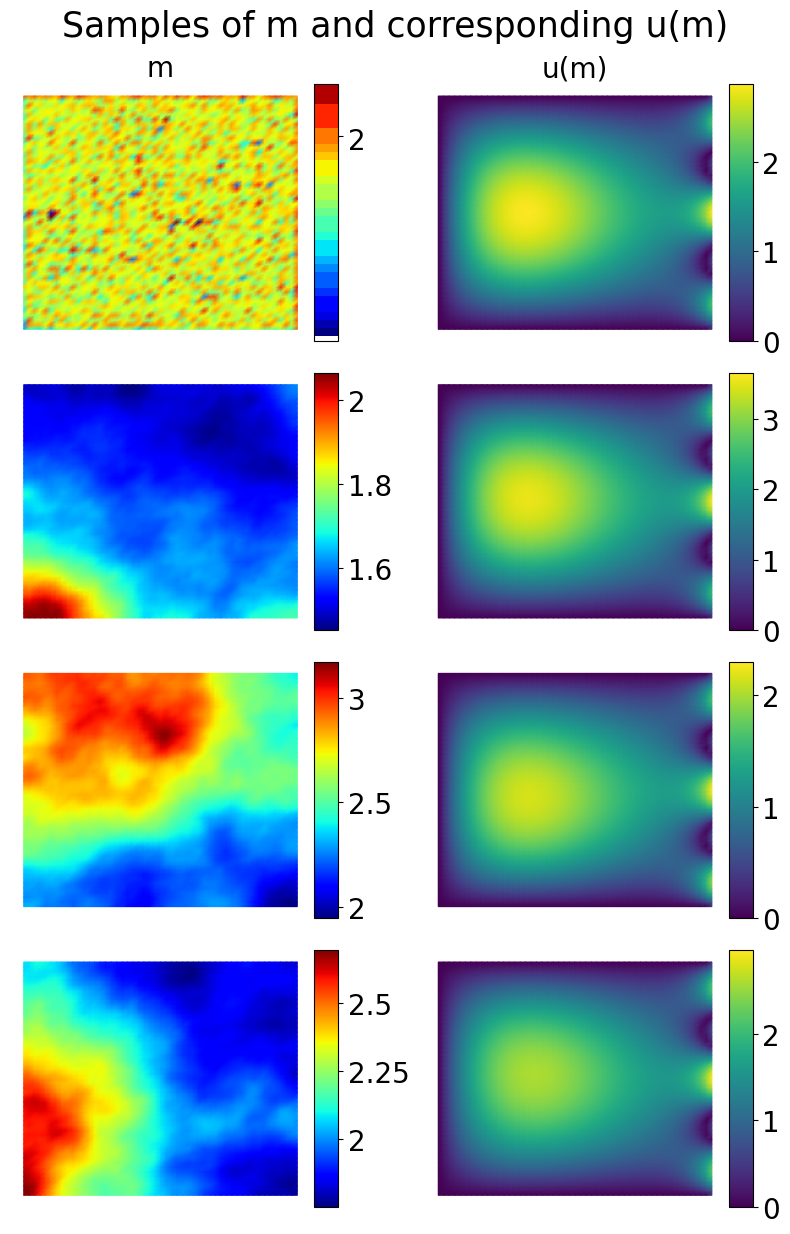

In [11]:
rows = 4
cols = 2
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(8, 12))

u_vec = None
u_tag = ['m', 'u(m)']
cmap_vec = ['jet', 'viridis']

m = dl.Function(model.Vm).vector()
u = dl.Function(model.Vu).vector()

for i in range(rows):

    m.zero()
    if i > 0:
        m.axpy(1., model.prior_sampler.get())
    else:
        m.axpy(1., model.prior_sampler.mean)
    
    model.solveFwd(m, m_is_fn = False)
    u = model.u_fn.vector()
    
    u_vec = [m, u]

    for j in range(cols):
        V = model.Vu
        if i == 0:
            V = model.Vm
        
        cbar = field_plot_fenics(axs[i,j], u_vec[j], V, cmap = cmap_vec[j])

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j== 0:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')
        
        if i == 0:
            axs[i,j].set_title(u_tag[j], fontsize=fs)
        axs[i,j].axis('off')
    
fig.tight_layout()
fig.suptitle('Samples of m and corresponding u(m)', fontsize=1.25*fs, y=1.025)
fig.savefig(results_dir+'Poisson_sample_plots.png',  bbox_inches='tight')
plt.show()

In [12]:
a = model.prior_sampler.mean.get_local()
print('mean:', a.mean(), a.min(), a.max())
a = model.prior_sampler.get().get_local()
print('sample:', a.mean(), a.min(), a.max())

mean: 1.9999999999999987 1.999999999999992 2.000000000000002
sample: 2.483446922348543 1.8632893729513142 3.699181228589958


## Generate data

In [ ]:
num_samples = 2000

m_samples = np.zeros((num_samples, model.Vm.dim()))
u_samples = np.zeros((num_samples, model.Vu.dim()))

m = dl.Function(model.Vm).vector()
u = dl.Function(model.Vu).vector()

for i in range(num_samples):

    start_time = time.perf_counter()

    m.zero()
    if i > 0:
        m.axpy(1., model.prior_sampler.get())
    else:
        m.axpy(1., model.prior_sampler.mean)
    
    model.solveFwd(m, m_is_fn = False)
    u = model.u_fn.vector()

    # save
    m_samples[i, :] = m.get_local()
    u_samples[i, :] = u.get_local()

    end_time = time.perf_counter()
    sample_time = end_time - start_time

    if i % 100 == 0:
        print('Sample {:4d} took {:.3f} seconds'.format(i, sample_time))

print(m_samples.shape, u_samples.shape)

Sample    0 took 0.042 seconds
Sample  100 took 0.032 seconds
Sample  200 took 0.032 seconds
Sample  300 took 0.039 seconds
Sample  400 took 0.035 seconds
Sample  500 took 0.047 seconds
Sample  600 took 0.033 seconds
Sample  700 took 0.036 seconds
Sample  800 took 0.036 seconds
Sample  900 took 0.031 seconds
Sample 1000 took 0.034 seconds
Sample 1100 took 0.035 seconds
Sample 1200 took 0.039 seconds
Sample 1300 took 0.037 seconds
Sample 1400 took 0.032 seconds
Sample 1500 took 0.032 seconds
Sample 1600 took 0.032 seconds
Sample 1700 took 0.032 seconds
Sample 1800 took 0.035 seconds
Sample 1900 took 0.033 seconds
(2000, 2601) (2000, 2601)


In [14]:
# data to save
np.savez(results_dir + 'Poisson_samples.npz', \
        m_samples = m_samples, \
        u_samples = u_samples, num_samples = num_samples, \
        m_dim = model.Vm.dim(), u_dim = model.Vu.dim(), \
        fe_order = model.fe_order, nx = model.nx, ny = model.ny, \
        correlation_length = correlation_length, \
        gamma = model.prior_sampler.gamma, \
        delta = model.prior_sampler.delta, \
        alpha_m = model.prior_sampler.scale.values()[0], \
        mu_m = model.prior_sampler.translate.values()[0], \
        u_mesh_nodes = model.Vu.mesh().coordinates(), \
        m_mesh_nodes = model.Vm.mesh().coordinates(), \
        u_mesh_elements = model.Vu.mesh().cells(), \
        m_mesh_elements = model.Vm.mesh().cells())


# save mesh 
## to read, use the syntax
## mesh = dl.Mesh()
## with dl.XDMFFile(results_dir + 'u_mesh.xdmf') as infile:
##     infile.read(mesh)
with dl.XDMFFile(results_dir + 'Poisson_u_mesh.xdmf') as infile:
    infile.write(model.Vu.mesh())

with dl.XDMFFile(results_dir + 'Poisson_m_mesh.xdmf') as infile:
    infile.write(model.Vm.mesh())

In [20]:
model.Vu.mesh().coordinates().shape, model.Vu.mesh().cells().shape, model.Vm.dim(), model.Vu.dim(), model.Vm.mesh().coordinates().shape, model.Vm.mesh().cells().shape

((2601, 2), (5000, 3), 2601, 2601, (2601, 2), (5000, 3))

### Interpolate function at nodal values to meshgrid for FNO

In [ ]:
num_grid_x, num_grid_y = 100, 100
grid_x, grid_y = np.meshgrid(np.linspace(0, 1, num_grid_x), np.linspace(0, 1, num_grid_y), indexing='ij')

fe_m_nodes = model.Vm.mesh().coordinates()
fe_u_nodes = model.Vu.mesh().coordinates()

# test griddata
fe_m = m_samples[0, :]
fe_u = u_samples[0, :]

grid_m = griddata(fe_m_nodes, fe_m, (grid_x, grid_y), method='linear')
grid_u = griddata(fe_u_nodes, fe_u, (grid_x, grid_y), method='linear')

print('grid_m: {}, grid_u: {}'.format(grid_m.shape, grid_u.shape))

grid_m: (100, 100), grid_u: (100, 100)


In [23]:
# save all samples to file
grid_m_samples = np.zeros((num_samples, num_grid_x, num_grid_y))
grid_u_samples = np.zeros((num_samples, num_grid_x, num_grid_y))
for i in range(num_samples):
    start_time = time.perf_counter()
    
    grid_m_samples[i, :, :] = griddata(fe_m_nodes, m_samples[i, :], (grid_x, grid_y), method='linear')
    grid_u_samples[i, :, :] = griddata(fe_u_nodes, u_samples[i, :], (grid_x, grid_y), method='linear')

    end_time = time.perf_counter()
    sample_time = end_time - start_time

    if i % 100 == 0:
        print('Sample {:4d} took {:.3f} seconds'.format(i, sample_time))

print(grid_m_samples.shape, grid_u_samples.shape)

Sample    0 took 0.127 seconds
Sample  100 took 0.092 seconds
Sample  200 took 0.092 seconds
Sample  300 took 0.093 seconds
Sample  400 took 0.089 seconds
Sample  500 took 0.089 seconds
Sample  600 took 0.086 seconds
Sample  700 took 0.088 seconds
Sample  800 took 0.084 seconds
Sample  900 took 0.089 seconds
Sample 1000 took 0.086 seconds
Sample 1100 took 0.088 seconds
Sample 1200 took 0.087 seconds
Sample 1300 took 0.089 seconds
Sample 1400 took 0.087 seconds
Sample 1500 took 0.087 seconds
Sample 1600 took 0.086 seconds
Sample 1700 took 0.087 seconds
Sample 1800 took 0.093 seconds
Sample 1900 took 0.091 seconds
(2000, 100, 100) (2000, 100, 100)


In [24]:
# data to save
np.savez(results_dir + 'Poisson_FNO_samples.npz', \
        grid_m_samples = grid_m_samples, \
        grid_u_samples = grid_u_samples, num_samples = num_samples, \
        num_grid_x = num_grid_x, num_grid_y = num_grid_y, \
        grid_x = grid_x, grid_y = grid_y)

### Test data by loading

In [11]:
data_load = np.load(results_dir + 'Poisson_samples.npz')
data_load['m_samples'].shape, data_load['u_samples'].shape, data_load['m_dim'], data_load['u_dim']

((2000, 2601), (2000, 2601), array(2601), array(2601))

In [14]:
X = data_load['u_mesh_nodes']
X.shape, np.min(X, axis = 0), np.max(X, axis = 0)  

((2601, 2), array([0., 0.]), array([1., 1.]))